In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from catboost import CatBoostClassifier

from lightgbm import LGBMRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import warnings

# Установка параметров для игнорирования предупреждений
warnings.filterwarnings('ignore')

pd.set_option('display.width', 200)


In [2]:
# Загрузка данных
data = pd.read_csv('data\\train.csv')

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Функция для извлечения обращений из имени
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# Создание нового столбца 'Title' с обращениями
data['Title'] = data['Name'].apply(extract_title)

# Замена пропусков в возрасте медианой по каждому обращению
data['Age'] = data.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# Удаление столбца 'Title' после замены пропусков
data.drop('Title', axis=1, inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
# Находим самое частое значение в столбце 'Embarked'
most_common_embarked = data['Embarked'].mode()[0]

# Заменяем пропущенные значения в столбце 'Embarked' на самое частое значение
data['Embarked'].fillna(most_common_embarked, inplace=True)

In [7]:
# Подсчет пропусков по каждому столбцу
missing_values = data.isnull().sum()

# Вывод количества пропусков
print(missing_values)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64


In [8]:
# Вычислим среднюю стоимость билетов как по классам, так и по первым буквам кабин
avg_ticket_price_by_class_cabin = data.groupby(['Pclass', data['Cabin'].str[0]])['Fare'].mean()
avg_ticket_price_by_class_cabin

Pclass  Cabin
1       A         39.623887
        B        113.505764
        C        100.151341
        D         63.324286
        E         55.740168
        T         35.500000
2       D         13.166675
        E         11.587500
        F         23.750000
3       E         11.000000
        F         10.611660
        G         13.581250
Name: Fare, dtype: float64

In [9]:
# Заменим значения кабины на ближайщее среднее значение цены билета

# Условие для замены пропусков в зависимости от класса
condition_1 = (data['Pclass'] == 1) & (data['Cabin'].isnull())
condition_2 = (data['Pclass'] == 2) & (data['Cabin'].isnull())
condition_3 = (data['Pclass'] == 3) & (data['Cabin'].isnull())

# Замена пропусков в столбце "Cabin" в зависимости от класса
data.loc[condition_1, 'Cabin'] = 'D'
data.loc[condition_2, 'Cabin'] = 'F'
data.loc[condition_3, 'Cabin'] = 'G'
# Убираем все символы после первой буквы в столбце Cabin
data['Cabin'] = data['Cabin'].str[0]

In [10]:
# Преобразование категориальных переменных в числовые методом get_dummies
data = pd.get_dummies(data, columns=['Embarked', 'Sex', 'Cabin'], drop_first=True)

In [11]:
data.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked_Q,Embarked_S,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,1,0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,False,True,True,False,False,False,False,False,True,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,False,False,False,False,True,False,False,False,False,False
2,3,1,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,False,True,False,False,False,False,False,False,True,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,False,True,False,False,True,False,False,False,False,False
4,5,0,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,False,True,True,False,False,False,False,False,True,False


In [12]:
# Поиск столбцов с пропущенными значениями
columns_with_missing_values = data.columns[data.isnull().any()]

if len(columns_with_missing_values) > 0:
    print("Столбцы с пропущенными значениями:")
    for column in columns_with_missing_values:
        print(column)
else:
    print("Пропущенные значения не обнаружены.")

Пропущенные значения не обнаружены.


In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Embarked_Q   891 non-null    bool   
 10  Embarked_S   891 non-null    bool   
 11  Sex_male     891 non-null    bool   
 12  Cabin_B      891 non-null    bool   
 13  Cabin_C      891 non-null    bool   
 14  Cabin_D      891 non-null    bool   
 15  Cabin_E      891 non-null    bool   
 16  Cabin_F      891 non-null    bool   
 17  Cabin_G      891 non-null    bool   
 18  Cabin_T      891 non-null    bool   
dtypes: bool(

## CatBoost 

In [14]:
cat_features=['Name', 'Ticket']

# Признаки (X) и целевая переменная (y)
X = data.drop(['Survived'], axis=1)
y = data['Survived']


In [15]:

# Разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание экземпляра модели CatBoostClassifier
model = CatBoostClassifier(verbose=False)

# Обучение модели
model.fit(X_train, y_train, cat_features=cat_features)

# Предсказание на тестовой выборке
y_pred = model.predict(X_test)

# Вычисление метрики accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8491620111731844


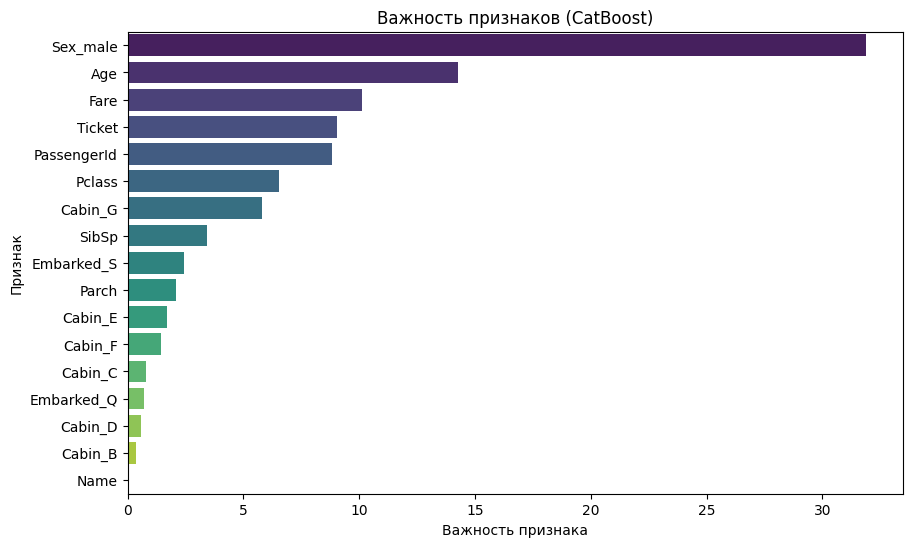

In [30]:
# Получение важности признаков
feature_importance = model.feature_importances_

# Создание DataFrame для визуализации
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Размер графика
plt.figure(figsize=(10, 6))

# График важности признаков
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков (CatBoost)')
plt.show()

In [16]:
# Загрузка тестовых данных
test = pd.read_csv('data\\test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [17]:
# Функция для извлечения обращений из имени
def extract_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

# Создание нового столбца 'Title' с обращениями
test['Title'] = test['Name'].apply(extract_title)

# Замена пропусков в возрасте медианой по каждому обращению
test['Age'] = test.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))

# Удаление столбца 'Title' после замены пропусков
test.drop('Title', axis=1, inplace=True)

In [18]:
# Находим самое частое значение в столбце 'Embarked'
most_common_embarked = test['Embarked'].mode()[0]

# Заменяем пропущенные значения в столбце 'Embarked' на самое частое значение
test['Embarked'].fillna(most_common_embarked, inplace=True)

In [19]:
# Заменим значения кабины на ближайщее среднее значение цены билета

# Условие для замены пропусков в зависимости от класса
condition_1 = (test['Pclass'] == 1) & (test['Cabin'].isnull())
condition_2 = (test['Pclass'] == 2) & (test['Cabin'].isnull())
condition_3 = (test['Pclass'] == 3) & (test['Cabin'].isnull())

# Замена пропусков в столбце "Cabin" в зависимости от класса
test.loc[condition_1, 'Cabin'] = 'D'
test.loc[condition_2, 'Cabin'] = 'F'
test.loc[condition_3, 'Cabin'] = 'G'
# Убираем все символы после первой буквы в столбце Cabin
test['Cabin'] = test['Cabin'].str[0]

In [20]:
# Преобразование категориальных переменных в числовые методом get_dummies
test = pd.get_dummies(test, columns=['Embarked', 'Sex', 'Cabin'], drop_first=True)


In [21]:
# Определение различий в столбцах между двумя наборами данных
extra_feature = set(X.columns) - set(test.columns)

# Удаление лишнего признака из DataFrame data, если такой есть
if extra_feature:
    X.drop(columns=list(extra_feature), inplace=True)
    print(f"Удален лишний признак из DataFrame X: {extra_feature}")
else:
    print("Не обнаружено лишних признаков в DataFrame X.")

# Проверка наличия дополнительных признаков в DataFrame test
extra_feature_test = set(test.columns) - set(X.columns)
if extra_feature_test:
    print(f"Дополнительные признаки в DataFrame test: {extra_feature_test}")
else:
    print("Не обнаружено дополнительных признаков в DataFrame test.")


Удален лишний признак из DataFrame X: {'Cabin_T'}
Не обнаружено дополнительных признаков в DataFrame test.


In [22]:
test

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Embarked_Q,Embarked_S,Sex_male,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G
0,892,3,"Kelly, Mr. James",34.5,0,0,330911,7.8292,True,False,True,False,False,False,False,False,True
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",47.0,1,0,363272,7.0000,False,True,False,False,False,False,False,False,True
2,894,2,"Myles, Mr. Thomas Francis",62.0,0,0,240276,9.6875,True,False,True,False,False,False,False,True,False
3,895,3,"Wirz, Mr. Albert",27.0,0,0,315154,8.6625,False,True,True,False,False,False,False,False,True
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",22.0,1,1,3101298,12.2875,False,True,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",28.5,0,0,A.5. 3236,8.0500,False,True,True,False,False,False,False,False,True
414,1306,1,"Oliva y Ocana, Dona. Fermina",39.0,0,0,PC 17758,108.9000,False,False,False,False,True,False,False,False,False
415,1307,3,"Saether, Mr. Simon Sivertsen",38.5,0,0,SOTON/O.Q. 3101262,7.2500,False,True,True,False,False,False,False,False,True
416,1308,3,"Ware, Mr. Frederick",28.5,0,0,359309,8.0500,False,True,True,False,False,False,False,False,True


In [23]:
# Создание экземпляра модели CatBoostClassifier
model = CatBoostClassifier(verbose=False)

# Обучение модели
model.fit(X, y, cat_features=cat_features)

In [25]:
predictions = model.predict(test)

# Создание DataFrame с предсказаниями
submission = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': predictions})

# Сохранение предсказаний в файл
submission.to_csv('gender_submission.csv', index=False)